# Classification: Predict Jumpstarter

## Table of Contents

1. Importing Packages

2. Loading Data

3. Exploratory Data Analysis (EDA)

4. Feature Engineering
  
6. Modeling

7. Model Performance

8. Model Explanations

---

## 1. Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

---

## 2. Loading the Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_with_no_labels.csv')

In [3]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


---

## 3. Exploratory Data Analysis (EDA)

In [5]:
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [6]:
test.isnull().sum()

message    0
tweetid    0
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


In [9]:
train['tweetid'].nunique()

15819

In [10]:
negative_count = (train['sentiment'] == -1).sum()
negative_count

1296

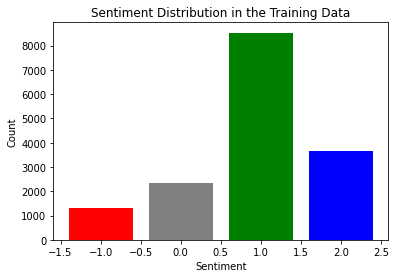

In [11]:
import matplotlib.pyplot as plt

# Count occurrences for each sentiment value
negative_count = (train['sentiment'] == -1).sum()
neutral_count = (train['sentiment'] == 0).sum()
positive_count = (train['sentiment'] == 1).sum()
positive_count2 = (train['sentiment'] == 2).sum()


# Data for the histogram
counts = [negative_count, neutral_count, positive_count, positive_count2]
sentiments = [-1, 0, 1, 2]

# Plot the histogram
plt.bar(sentiments, counts, color=['red', 'grey', 'green', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in the Training Data')
plt.show()


## Word cloud.....?

### Sentiment Definitions (from Kaggle)

#### 2 News: the tweet links to factual news about climate change

#### 1 Pro: the tweet supports the belief of man-made climate change

#### 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

#### -1 Anti: the tweet does not believe in man-made climate change

What we notice is that we have imbalanced data. What would your next steps be in this example?

---

## 4. Feature Engineering

#### Natural Language Processing

#### Lowercasing & Removing Punctuation

In [12]:
import string

#Remove punctuation and lowercase the words
def remove_punctuation(long_str):
    # Lowercase the word
    long_str = long_str.lower()
    #Had to add manually removing certain words since they don't add anything 
    #(such as amp and link with http in)
    long_str.replace('http','').replace('amp','').replace('www','').replace('https','')
    return ''.join([x for x in long_str if (x in string.ascii_lowercase)|(x == ' ')])

#### Tokenization 
(tokenisation of text was done as part of the combined process since it is a single step)

#### Lemmatization & Stemming

In [14]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# Set up lemmatizatier 
lemmatizer = WordNetLemmatizer()

# Set up Stemmer - (finds base form of word)
stemmer = SnowballStemmer('english')

# Return base stem/lemmatized form of a word
def get_base(tokens, option = 'lemmatize'): 
    #The base form uses lemmatization since it gets the base 
    #form where stemming gets the form without affixes and prefixes, 
    #the base form contains more information than a simply stripped form
    base_tokens = []
    if option == 'lemmatize': #Use lemmatization to build word dictionary
        base_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    else: #Use Stemming to build word dictionary
        base_tokens = [stemmer.stem(token) for token in tokens]
    return base_tokens

[nltk_data] Downloading package wordnet to /home/schup001/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/schup001/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Stop words

In [15]:
nltk.download('stopwords')
from nltk.corpus import stopwords

# Remove stopwords - we only want words that affect meaning and convey information, stop words generatlly don't 
def remove_stopwords(tokens):
    return [t for t in tokens if (t not in stopwords.words('english'))]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/schup001/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Combined Processes

In [16]:
# Set up word Tokenizer
tokeniser = TreebankWordTokenizer()

# Apply process to dataframe entries 
# 1. Lowercase and remove punctuation from string
# 2. Tokenise string - returns an array of 'tokens' (effectively words)
# 3. Remove stopwords from token array - (had to scrap it since it decreased accuracy)
# 4. Get base forms of words - lemmatize or get stem of tokens 
def tokens_from_dataframe(df,column):
    new_col = []
    for index, row in df.iterrows():
        words_str = row[column]
        words = remove_punctuation(words_str)
        # Tokenize the data - convert string to indivisual words or 'tokens'
        tokens = tokeniser.tokenize(words)
        # I removed the stopword removing code, this is due to stopwords containing negatives etc which 
        # completely change the context of a tweet
        #tokens = remove_stopwords(tokens)
        tokens = get_base(tokens)
        new_col.append(tokens)
    df['tokens'] = new_col
    return df 

df_train = tokens_from_dataframe(train,'message')
print(df_train.head())

   sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                              tokens  
0  [polyscimajor, epa, chief, doesnt, think, carb...  
1  [it, not, like, we, lack, evidence, of, anthro...  
2  [rt, rawstory, researcher, say, we, have, thre...  
3  [todayinmaker, wired, wa, a, pivotal, year, in...  
4  [rt, soynoviodetodas, it, and, a, racist, sexi...  


---

## Scikit-learn

#### TF-IDF (Term Frequency - Inverse Document Frequency)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Get TF-IDF value
def apply_vectorising(df,column,target_column,max_feat = 2000,n_grams = (1,2)):
    text_from_tokens = []
    for index, row in df.iterrows():
        text_from_tokens.append(" ".join(row[column]))
    column = column+'_full_str'
    df[column] = text_from_tokens
    # Create a TF-IDF vectoriser instance
    vectorizer = TfidfVectorizer(#smooth_idf=True,
                                 #use_idf=True,
                                 #max_features=max_feat,
                                 ngram_range = n_grams)
    temp = vectorizer.fit_transform(df[column])
    return temp,vectorizer

tfidf,tfidf_vectorizer = apply_vectorising(df_train,'tokens','sentiment', n_grams = (1,2))

Are there any other vectorisers you know of that you can use?

What kind of hyperparameters can you set with vectorisers?

In [24]:
y = np.array(train['sentiment'])
y

array([ 1,  1,  2, ...,  0, -1,  0])

### Test dataset.......?

Remember to apply all your cleaning and engineering steps to your test dataset too!

---

## 5. Modelling

In [25]:
# split up our data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf, train['sentiment'], test_size = 0.2, random_state = 42)

In [26]:
# fit a Logistic Regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
lr = LogisticRegression(
    #solver = 'newton-cg',
    class_weight = 'balanced',
    random_state = 42,
    multi_class = 'multinomial',
    C = 60,
    max_iter = 100
    ).fit(X_train,y_train)

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred, labels=[-1,0,1,2]))

              precision    recall  f1-score   support

          -1       0.74      0.51      0.61       278
           0       0.57      0.47      0.52       425
           1       0.80      0.86      0.83      1755
           2       0.76      0.80      0.78       706

    accuracy                           0.76      3164
   macro avg       0.72      0.66      0.68      3164
weighted avg       0.76      0.76      0.76      3164



/home/schup001/.virtualenv/onboarding_example/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
#Grid search to find best version of DecisionTree
clean_forrest = DecisionTreeClassifier(class_weight ='balanced')

parameters = {'criterion': ['gini', 'entropy']
            ,'max_depth': np.arange(5,26,5).tolist()
            ,'min_samples_leaf': np.arange(4,21,2).tolist()
            #,'class_weight': 'balanced'
            ,'random_state': [42]}
gs_dtc = GridSearchCV(clean_forrest, parameters)
gs_dtc.fit(X_train,y_train)

y_pred = gs_dtc.predict(X_test)
print(classification_report(y_test, y_pred, labels=[-1,0,1,2]))

In [18]:
from sklearn.ensemble import RandomForestClassifier
#Grid search to find best version of RandomForrest
clean_rf = RandomForestClassifier()

parameters = {'criterion': ['gini', 'entropy', 'logloss']
            , 'n_estimators': np.arange(20,101,20).tolist()
            ,'max_depth': np.arange(5,26,5).tolist()
            ,'min_samples_leaf': np.arange(4,21,2).tolist()
            ,'class_weight': ['balanced','balanced_subsample']
            ,'random_state': [42]}
gs_rf = GridSearchCV(clean_rf, parameters)
gs_rf.fit(X_train,y_train)

y_pred = gs_rf.predict(X_test)
print(classification_report(y_test, y_pred, labels=[-1,0,1,2]))

In [ ]:
from sklearn.neural_network import MLPClassifier
#Grid search to find best version of MLP
clean_mlp = MLPClassifier()

parameters = {
            'n_estimators':[[10,10],[5,5],[20,20],[10,5],[20,10]]
            ,'activation':['tanh','logistic','relu']
            ,'learning_rate': ['constant','adaptive']
            ,'random_state': [42]}
gs_mlp = GridSearchCV(clean_mlp, parameters)
gs_mlp.fit(X_train,y_train)

y_pred = gs_mlp.predict(X_test)
print(classification_report(y_test, y_pred, labels=[-1,0,1,2]))

#### Final Model Predictions
My best model after the gridsearch was the logistic regression I trained first, it's ability to regularize seems to have won it the top spot.

I would recommend going deeper with the grid search parameters for future versions since the other models could have potentially performed better given a better chance

#### Transform Test data

In [27]:
#Apply all steps to the test data
df_pred = tokens_from_dataframe(test,'message')
text_from_tokens = []
for index, row in df_pred.iterrows():
    text_from_tokens.append(" ".join(row['tokens']))
column = 'tokens'+'_full_str'
df_pred[column] = text_from_tokens
test = tfidf_vectorizer.transform(df_pred[column])
y_pred = lr.predict(test)

Now we are aware of many more classification models - remember to try out at least **three** to allow you to make comparisons between their performances

---

## 6. Model Performance

In [23]:
# Calculate accuracy score
acc = accuracy_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='micro')

# Calculate precision score
prec = precision_score(y_test, y_pred, average='micro')

# Calculate recall score
rec = recall_score(y_test, y_pred, average='micro')


### Additional note from our webinar discussion:

Regarding the 'average' parameter with each of these scoring methods, which 'average' do we use? This is the difference between them, particularly for f1 scores (all images taken from [this link](https://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example/), which has a nice discussion of the difference in these averages for f1 scores):

- **Micro**: Calculates metric based on the **total** number of True Positives, False Positives and True Negatives, rather than looking at predicitons per-class. 

![](https://iamirmasoud.com/wp-content/uploads/2023/04/image-39.png)

- **Macro**: Calculates the average metrics score across all classes metric scores, *without* taking into account the size of each class (does not account for any imbalanced data)

![](https://iamirmasoud.com/wp-content/uploads/2023/04/image-34.png)

- **Weighted**: Calculates the average metrics score across all classes metric scores, *while* taking into account the size of each class

![](https://miro.medium.com/v2/resize:fit:1400/1*0SN1NHpAz154YOjgBLCCYw.png)


In [27]:
f1

0.7493678887484196

In [28]:
#from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names = ['-1', '0', '1', '2']))

              precision    recall  f1-score   support

          -1       0.69      0.46      0.55       278
           0       0.55      0.50      0.52       425
           1       0.79      0.84      0.81      1755
           2       0.76      0.80      0.78       706

    accuracy                           0.75      3164
   macro avg       0.70      0.65      0.67      3164
weighted avg       0.74      0.75      0.74      3164



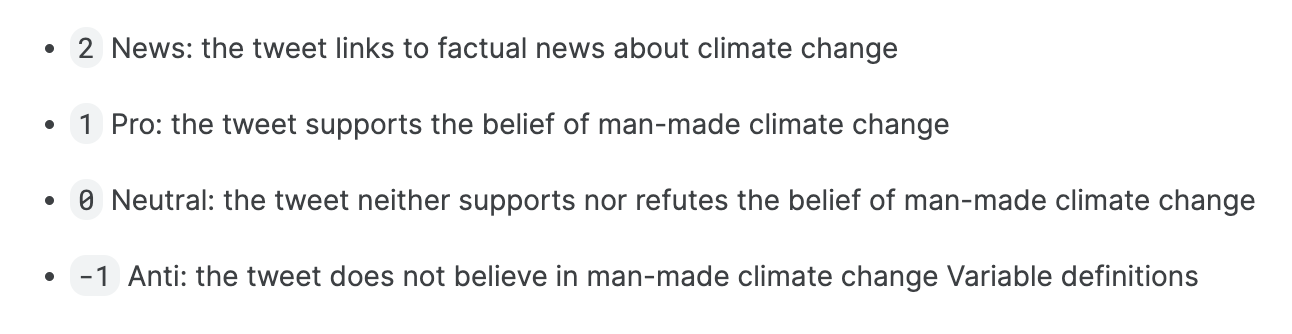

Implement some hyperparameter tuning or use of GridSearch to help you improve model performance

Are there any other steps that one could use to improve models? Think about if anything else could be applied in the Feature Engineering stages...

## Create a  ".CSV" File

Remember we still need to apply our model to our test data to submit to Kaggle.

- Make sure the test data is cleaned/engineered in the same way as our training data
- Use our trained model to make predictions on the prepped test data
- Take the tweetid column from the original test data, and our predictions from our model to create a new dataframe with those two columns
- Export to CSV
- Submit to Kaggle

In [28]:
#Final model prediction for submission
values = np.vstack((df_pred['tweetid'],y_pred)).T
pd.DataFrame(values,columns = ['tweetid','sentiment']).to_csv('submission.csv',index=False)